In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier   
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input
from keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix   
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Confusion Matrix Function

In [2]:
def cf(y_true, y_pred, fname, title):
    '''
    Create a confusion matrix plot save it into a file
    Inputs:
    y_true: actual labels
    y_pred: prediction labels
    fname: file name
    title: title of the plot
    Outputs:
    None
    '''
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = '0'
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    ax = sns.heatmap(cm, cmap= "Blues", annot=annot, fmt='')
    ax.set_title(title);
    ax.xaxis.set_ticklabels(['Normal','Attack'])
    ax.yaxis.set_ticklabels(['Normal','Attack'])
    plt.savefig(fname, dpi=300)
    plt.show()
    

# Pre-processing Function

In [3]:
def preproc(X, y):
    '''
    Pre-process the data
    Inputs: 
    X: input features
    y: input labels
    Outputs:
    X_train: training samples
    X_val: validation samples
    X_test: testing samples 
    y_train: training labels
    y_val: validation labels
    y_test: testing labels
    
    '''
    # split the data into train, validation, and test sets
    X_dev, X_test, y_dev, y_test = train_test_split( X, y, stratify = y, test_size = 0.2) # Split the data into test and development sets
    X_train, X_val, y_train, y_val = train_test_split( X_dev, y_dev, stratify = y_dev, test_size = 0.2) #split the development set into the train and validation
    
    # handle missing values
    imputer = SimpleImputer(missing_values = np.NaN , strategy= 'mean') # Define the imputer with mean strategy
    X_train = imputer.fit_transform(X_train) # Fit the imputer on the training data and transfer it
    X_val = imputer.transform(X_val) # Transform the validation data using the imputer
    X_test = imputer.transform(X_test) # Transform the testing data using the imputer
    
    # normalize the data
    scaler = MinMaxScaler()   # Define the scaler
    X_train = scaler.fit_transform(X_train)   # Fit the scaler on the data
    X_val = scaler.transform(X_val)   # Apply the trained scaler on the validation data
    X_test = scaler.transform(X_test)   # Apply the trained scaler on the test data
    
    return X_train, X_val, X_test, y_train, y_val, y_test
    

# Autoencoder Representation Leanring Function

In [4]:
def rep_learning(X, rep = 8):
    '''
    This function defines an autoencoder representation learning model
    Inputs:
    X: input features
    rep: new representation dims
    Outputs:
    model: encoder of the autoencoder
    
    '''
    #Encoder part
    input_X= Input(shape = (X.shape[1],)) # Input shape of the data
    encoded = Dense(units = 200, activation = 'tanh')(input_X)
    encoded = Dense(units = 64, activation = 'tanh')(encoded)
    encoded = Dense(units = rep, activation = 'tanh')(encoded) # Representation layer
    #Decoder part
    decoded = Dense(units = 64, activation = 'tanh')(encoded)
    decoded = Dense(units = 200, activation = 'tanh')(encoded)
    decoded = Dense(units = X.shape[1], activation = 'tanh')(decoded)
    
    autoencoder = Model(input_X, decoded)
    autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse'])
    
    autoencoder.fit(X, X, epochs = 100, batch_size = 256, shuffle = True)
    
    # Making a model using the encoder part
    model = Sequential() 
    model.add(autoencoder.layers[0]) 
    model.add(autoencoder.layers[1]) 
    model.add(autoencoder.layers[2]) 
    model.add(autoencoder.layers[3])

    return model

# Fully Connected Model Function

In [5]:
def fully_con(X_train, X_val, X_test, y_train, y_val, y_test):
    '''
    This function makes a fully connected model for classification and evaluates it
    Inputs:
    X_train: training samples
    X_val: validation samples
    X_test: testing samples 
    y_train: training labels
    y_val: validation labels
    y_test: testing labels
    Output:
    y_pred: predicted output
    
    '''
    
    # Categorize labels
    y_train_oh = to_categorical(y_train, num_classes= 2)  
    y_test_oh = to_categorical(y_test, num_classes= 2)
    y_val_oh = to_categorical(y_val, num_classes= 2)
    
    # Define the fully connected model for categorized labels
    model=Sequential()
    model.add(Dense(64, input_shape = (X_train.shape[1], ), activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(2,activation='softmax')) 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
    
    # Define callbacks
    model_name = "best_model.h5"
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 40)
    monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
    
    model.fit(X_train , y_train_oh, epochs = 200, batch_size = 256, shuffle = True, validation_data=(X_val, y_val_oh), callbacks= [early_stop, monitor])
    
    model.load_weights(model_name) # Loading model weights    
    y_pred = np.argmax(model.predict(X_test), axis = 1) # Predict the labels on the test data
    
    return y_pred

# Models

In [6]:
def run_models(X_train, X_val, X_test, y_train, y_val, y_test , scen):
    '''
    This function run 7 models including SVM, KNN, DT, RF, AB, GB, and ANN on the passed data and show their performance.
    Inputs:
    X_train: Training data, np.array
    X_val: Validation data used in ANN model, np.array
    X_test: Testing data, np.array
    y_train: Training labels, np.array
    y_val: validation labels, np.array
    y_test: Testting labels, np.array
    Outputs: 
    None
    '''
    print(scen)
    
    # train a decision tree model
    dtree_model = DecisionTreeClassifier()
    dtree_model.fit(X_train,y_train)
    # evaluate the model over test data
    y_pred_dtree = dtree_model.predict(X_test)
    print('\nDecisionTree : ')   
    print("Accuracy:", accuracy_score(y_test, y_pred_dtree))
    print("Precision:", precision_score(y_test, y_pred_dtree))
    print("Recall:", recall_score(y_test, y_pred_dtree))
    print("f1-score:", f1_score(y_test, y_pred_dtree))
    fname = scen + "_DT"
    cf(y_test, y_pred_dtree, fname, "Decision Tree")
    
    # Train a SVM model 
    svm_model = SVC(kernel = 'linear')
    svm_model.fit(X_train, y_train)
    # evaluate the model over test data
    y_pred_svm = svm_model.predict(X_test)
    print('\nSVM : ')   
    print("Accuracy:", accuracy_score(y_test, y_pred_svm))
    print("Precision:", precision_score(y_test, y_pred_svm))
    print("Recall:", recall_score(y_test, y_pred_svm))
    print("f1-score:", f1_score(y_test, y_pred_svm))
    fname = scen + "_svm"
    cf(y_test, y_pred_svm, fname, "Support Vector Machine")
    
    # train a KNN classifier
    knn_model = KNeighborsClassifier(n_neighbors= 3)
    knn_model.fit(X_train, y_train)
    # evaluate the model over test data
    y_pred_knn = knn_model.predict(X_test)
    print('\nKNN : ')   
    print("Accuracy:", accuracy_score(y_test, y_pred_knn))
    print("Precision:", precision_score(y_test, y_pred_knn))
    print("Recall:", recall_score(y_test, y_pred_knn))
    print("f1-score:", f1_score(y_test, y_pred_knn))
    fname = scen + "_KNN"
    cf(y_test, y_pred_knn, fname, "K-Nearest Neighbors")
    
    # train a random forest model
    randonforest_model = RandomForestClassifier(n_estimators= 50)
    randonforest_model.fit(X_train, y_train)
    # evaluate the model over test data
    y_pred_rf = randonforest_model.predict(X_test)
    print('\nRandomForest :')   
    print("Accuracy:", accuracy_score(y_test, y_pred_rf))
    print("Precision:", precision_score(y_test, y_pred_rf))
    print("Recall:", recall_score(y_test, y_pred_rf))
    print("f1-score:", f1_score(y_test, y_pred_rf))
    fname = scen + "_RF"
    cf(y_test, y_pred_rf, fname, "Random Forest")
    
    # train a gradient boosting model
    gradientboost_model = GradientBoostingClassifier(n_estimators= 50)
    gradientboost_model.fit(X_train, y_train)
    # evaluate the model over test data
    y_pred_gb = gradientboost_model.predict(X_test)
    print('\nGradientBoost : ')   
    print("Accuracy:", accuracy_score(y_test, y_pred_gb))
    print("Precision:", precision_score(y_test, y_pred_gb))
    print("Recall:", recall_score(y_test, y_pred_gb))
    print("f1-score:", f1_score(y_test, y_pred_gb))
    fname = scen + "_GB"
    cf(y_test, y_pred_gb, fname, "Gradient Boosting")
    
    # train a adaboost model
    adaboost_model = AdaBoostClassifier(n_estimators=10)
    adaboost_model.fit(X_train, y_train)
    # evaluate the model over test data
    y_pred_ab = adaboost_model.predict(X_test)
    print('\nAdaBoost : ')   
    print("Accuracy:", accuracy_score(y_test, y_pred_ab))
    print("Precision:", precision_score(y_test, y_pred_ab))
    print("Recall:", recall_score(y_test, y_pred_ab))
    print("f1-score:", f1_score(y_test, y_pred_ab))
    fname = scen + "_AB"
    cf(y_test, y_pred_ab, fname, "AdaBoost")
    
    # Train and evaluate the fully connected method
    y_pred_fc = fully_con(X_train, X_val, X_test, y_train, y_val, y_test)
    # evaluate the model over test data
    print('\nFully Connected : ')   
    print("Accuracy:", accuracy_score(y_test, y_pred_fc))
    print("Precision:", precision_score(y_test, y_pred_fc))
    print("Recall:", recall_score(y_test, y_pred_fc))
    print("f1-score:", f1_score(y_test, y_pred_fc))
    fname = scen + "_FC"
    cf(y_test, y_pred_fc, fname, "Fully Connected")
    

# Loading Datasets

In [7]:
# loading the Gas Pipeline data
data_gas = pd.read_csv("IanArffDataset.csv")

# extract label and features from the data
y_gas = data_gas["binary_result"]
X_gas = data_gas.drop(['binary_result' , 'categorized_result' , 'specific_result'] , axis = 1)
print(y_gas.shape)
print(X_gas.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'IanArffDataset.csv'

In [8]:
data_gas.head()

,address,function,length,setpoint,gain,reset_rate,deadband,cycle_time,rate,system_mode,control _scheme,pump,solenoid,pressure_measurement,crc_rate,command_response,time,binary_result,categorized_result,specific_result
0,4,3,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12869,1,1418682163,0,0,0
1,4,3,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.689655,12356,0,1418682163,0,0,0
2,4,16,90,10.0,115.0,0.2,0.5,1.0,0.0,0.0,1.0,0.0,0.0,NaN,17219,1,1418682165,0,0,0
3,4,16,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17718,0,1418682165,0,0,0
4,4,3,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12869,1,1418682167,0,0,0


In [9]:
# loading the SWaT data
data_swat = pd.read_csv("SWaT_Dataset_Attack_v1.0.csv")

# extract label and features from the data
y_swat = data_swat["Label"]
X_swat = data_swat.drop(['Label'] , axis = 1)
print(y_swat.shape)
print(X_swat.shape)

(449919,)
(449919, 51)


In [10]:
data_swat.head()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Label
0,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,0
1,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,0
2,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,0
3,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,0
4,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,2,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,0


# Pre-processing the Data

In [11]:
# Pre-process Gas Pipeline data
X_train_gas, X_val_gas, X_test_gas, y_train_gas, y_val_gas, y_test_gas = preproc(X_gas, y_gas)

In [12]:
# Pre-process SWaT data
X_train_swat, X_val_swat, X_test_swat, y_train_swat, y_val_swat, y_test_swat = preproc(X_swat, y_swat)

# Run the Models on the Original Data

org

DecisionTree : 
Accuracy: 0.9469832137785384
Precision: 0.8933759944655828
Recall: 0.8601998334721066
f1-score: 0.8764740816153389


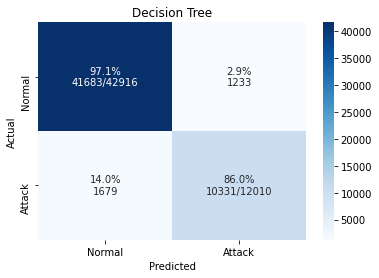


SVM : 
Accuracy: 0.8090703856097294
Precision: 1.0
Recall: 0.12681099084096586
f1-score: 0.22507943545407524


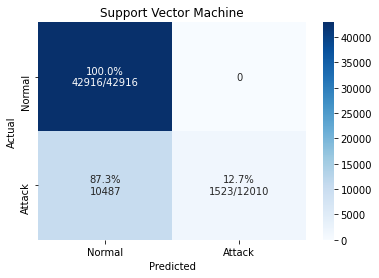


KNN : 
Accuracy: 0.9442886793139861
Precision: 0.8990547529873373
Recall: 0.8394671107410491
f1-score: 0.8682397519807096


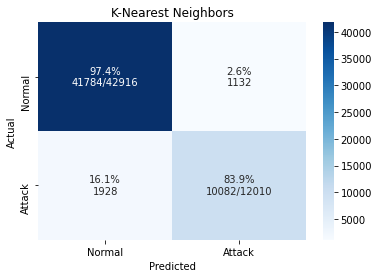


RandomForest :
Accuracy: 0.9372974547573099
Precision: 0.8990124836966648
Recall: 0.8034970857618651
f1-score: 0.8485754484699262


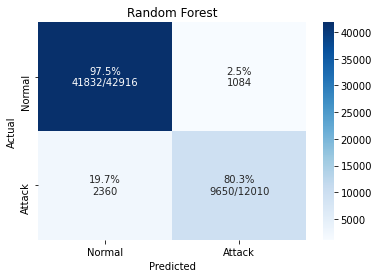


GradientBoost : 
Accuracy: 0.8431161926956269
Precision: 1.0
Recall: 0.2825145711906744
f1-score: 0.44056352658573


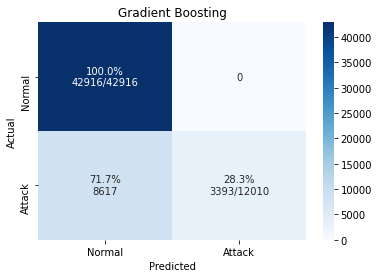


AdaBoost : 
Accuracy: 0.8250919418854459
Precision: 1.0
Recall: 0.20008326394671108
f1-score: 0.33344896968014986


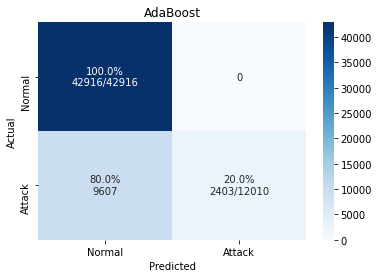

Epoch 1/200
687/687 [==============================] - 1s 1ms/step - loss: 0.4223 - accuracy: 0.8186 - val_loss: 0.3748 - val_accuracy: 0.8372
Epoch 2/200
687/687 [==============================] - 1s 946us/step - loss: 0.3652 - accuracy: 0.8410 - val_loss: 0.3569 - val_accuracy: 0.8451
Epoch 3/200
687/687 [==============================] - 1s 970us/step - loss: 0.3577 - accuracy: 0.8446 - val_loss: 0.3592 - val_accuracy: 0.8451
Epoch 4/200
687/687 [==============================] - 1s 1ms/step - loss: 0.3539 - accuracy: 0.8458 - val_loss: 0.3532 - val_accuracy: 0.8458
Epoch 5/200
687/687 [==============================] - 1s 952us/step - loss: 0.3518 - accuracy: 0.8465 - val_loss: 0.3488 - val_accuracy: 0.8478
Epoch 6/200
687/687 [==============================] - 1s 1ms/step - loss: 0.3519 - accuracy: 0.8466 - val_loss: 0.3506 - val_accuracy: 0.8474
Epoch 7/200
687/687 [==============================] - 1s 1ms/step - loss: 0.3506 - accuracy: 0.8471 - val_loss: 0.3530 - val_accuracy: 

Epoch 113/200
687/687 [==============================] - 1s 949us/step - loss: 0.3076 - accuracy: 0.8612 - val_loss: 0.3137 - val_accuracy: 0.8603
Epoch 114/200
687/687 [==============================] - 1s 958us/step - loss: 0.3075 - accuracy: 0.8612 - val_loss: 0.3153 - val_accuracy: 0.8592
Epoch 115/200
687/687 [==============================] - 1s 941us/step - loss: 0.3080 - accuracy: 0.8611 - val_loss: 0.3193 - val_accuracy: 0.8591
Epoch 116/200
687/687 [==============================] - 1s 922us/step - loss: 0.3118 - accuracy: 0.8603 - val_loss: 0.3154 - val_accuracy: 0.8597
Epoch 117/200
687/687 [==============================] - 1s 946us/step - loss: 0.3062 - accuracy: 0.8618 - val_loss: 0.3171 - val_accuracy: 0.8588
Epoch 118/200
687/687 [==============================] - 1s 921us/step - loss: 0.3063 - accuracy: 0.8618 - val_loss: 0.3142 - val_accuracy: 0.8603
Epoch 119/200
687/687 [==============================] - 1s 926us/step - loss: 0.3165 - accuracy: 0.8589 - val_loss: 0

Epoch 169/200
687/687 [==============================] - 1s 984us/step - loss: 0.3017 - accuracy: 0.8630 - val_loss: 0.3132 - val_accuracy: 0.8610
Epoch 170/200
687/687 [==============================] - 1s 961us/step - loss: 0.3020 - accuracy: 0.8627 - val_loss: 0.3149 - val_accuracy: 0.8606
Epoch 171/200
687/687 [==============================] - 1s 968us/step - loss: 0.3022 - accuracy: 0.8628 - val_loss: 0.3103 - val_accuracy: 0.8616
Epoch 172/200
687/687 [==============================] - 1s 1ms/step - loss: 0.3020 - accuracy: 0.8628 - val_loss: 0.3087 - val_accuracy: 0.8620
Epoch 173/200
687/687 [==============================] - 1s 956us/step - loss: 0.3020 - accuracy: 0.8628 - val_loss: 0.3137 - val_accuracy: 0.8592
Epoch 174/200
687/687 [==============================] - 1s 1ms/step - loss: 0.3017 - accuracy: 0.8628 - val_loss: 0.3103 - val_accuracy: 0.8612
Epoch 175/200
687/687 [==============================] - 1s 954us/step - loss: 0.3011 - accuracy: 0.8632 - val_loss: 0.316

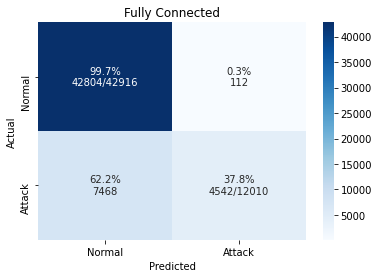

In [28]:
# Run the models on Gas Pipeline data
run_models(X_train_gas, X_val_gas, X_test_gas, y_train_gas, y_val_gas, y_test_gas, "org")

org

DecisionTree : 
Accuracy: 0.9993221017069701
Precision: 0.9964354263778448
Recall: 0.9979860856829
f1-score: 0.9972101532128972


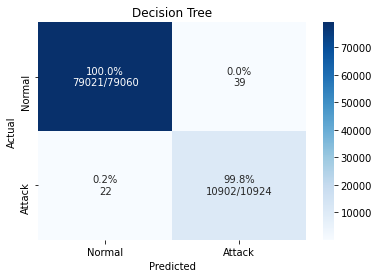


SVM : 
Accuracy: 0.966349573257468
Precision: 0.9779661016949153
Recall: 0.7394727206151592
f1-score: 0.8421601334445371


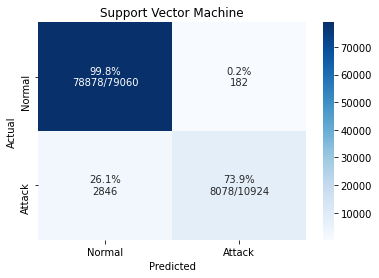


KNN : 
Accuracy: 0.9985108463726885
Precision: 0.9945004582951421
Recall: 0.9932259245697547
f1-score: 0.993862782815792


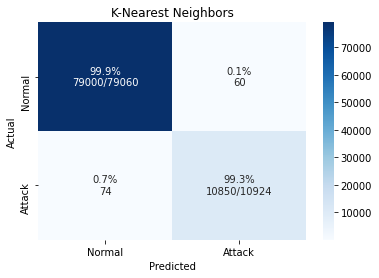


RandomForest :
Accuracy: 0.9997888513513513
Precision: 0.9990846681922196
Recall: 0.9991761259611863
f1-score: 0.9991303949837521


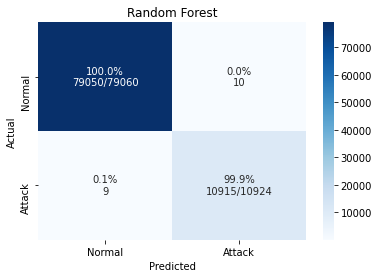


GradientBoost : 
Accuracy: 0.9776293563300142
Precision: 0.9964345403899721
Recall: 0.8186561699011351
f1-score: 0.8988391376451078


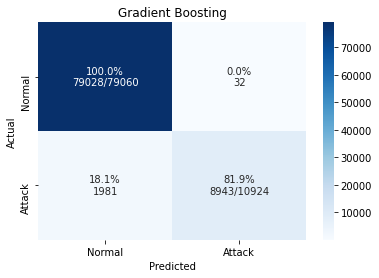


AdaBoost : 
Accuracy: 0.9620376955903271
Precision: 0.9680798004987531
Recall: 0.7107286708165507
f1-score: 0.8196790540540541


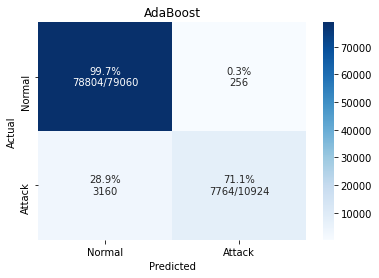

Epoch 1/200
1125/1125 [==============================] - 1s 1ms/step - loss: 0.1301 - accuracy: 0.9665 - val_loss: 0.0964 - val_accuracy: 0.9724
Epoch 2/200
1125/1125 [==============================] - 1s 992us/step - loss: 0.0911 - accuracy: 0.9775 - val_loss: 0.0853 - val_accuracy: 0.9808
Epoch 3/200
1125/1125 [==============================] - 1s 990us/step - loss: 0.0821 - accuracy: 0.9808 - val_loss: 0.0783 - val_accuracy: 0.9821
Epoch 4/200
1125/1125 [==============================] - 1s 1ms/step - loss: 0.0774 - accuracy: 0.9816 - val_loss: 0.0710 - val_accuracy: 0.9827
Epoch 5/200
1125/1125 [==============================] - 1s 1ms/step - loss: 0.0715 - accuracy: 0.9822 - val_loss: 0.0682 - val_accuracy: 0.9814
Epoch 6/200
1125/1125 [==============================] - 1s 1ms/step - loss: 0.0646 - accuracy: 0.9832 - val_loss: 0.0608 - val_accuracy: 0.9827
Epoch 7/200
1125/1125 [==============================] - 1s 1ms/step - loss: 0.0593 - accuracy: 0.9843 - val_loss: 0.0504 - va

Epoch 55/200
1125/1125 [==============================] - 1s 982us/step - loss: 0.0204 - accuracy: 0.9927 - val_loss: 0.0235 - val_accuracy: 0.9926
Epoch 56/200
1125/1125 [==============================] - 1s 972us/step - loss: 0.0216 - accuracy: 0.9924 - val_loss: 0.0251 - val_accuracy: 0.9916
Epoch 57/200
1125/1125 [==============================] - 1s 1ms/step - loss: 0.0207 - accuracy: 0.9926 - val_loss: 0.0200 - val_accuracy: 0.9925
Epoch 58/200
1125/1125 [==============================] - 1s 1ms/step - loss: 0.0210 - accuracy: 0.9926 - val_loss: 0.0281 - val_accuracy: 0.9913
Epoch 59/200
1125/1125 [==============================] - 1s 1ms/step - loss: 0.0203 - accuracy: 0.9927 - val_loss: 0.0183 - val_accuracy: 0.9932
Epoch 60/200
1125/1125 [==============================] - 1s 1ms/step - loss: 0.0207 - accuracy: 0.9927 - val_loss: 0.0230 - val_accuracy: 0.9919
Epoch 61/200
1125/1125 [==============================] - 1s 1ms/step - loss: 0.0201 - accuracy: 0.9928 - val_loss: 0.01

1125/1125 [==============================] - 1s 1ms/step - loss: 0.0117 - accuracy: 0.9953 - val_loss: 0.0136 - val_accuracy: 0.9953
Epoch 166/200
1125/1125 [==============================] - 1s 1ms/step - loss: 0.0127 - accuracy: 0.9952 - val_loss: 0.0119 - val_accuracy: 0.9954
Epoch 167/200
1125/1125 [==============================] - 1s 1ms/step - loss: 0.0120 - accuracy: 0.9953 - val_loss: 0.0153 - val_accuracy: 0.9938
Epoch 168/200
1125/1125 [==============================] - 1s 1ms/step - loss: 0.0121 - accuracy: 0.9952 - val_loss: 0.0096 - val_accuracy: 0.9965
Epoch 169/200
1125/1125 [==============================] - 1s 1ms/step - loss: 0.0119 - accuracy: 0.9954 - val_loss: 0.0191 - val_accuracy: 0.9941
Epoch 170/200
1125/1125 [==============================] - 1s 1ms/step - loss: 0.0114 - accuracy: 0.9955 - val_loss: 0.0125 - val_accuracy: 0.9953
Epoch 171/200
1125/1125 [==============================] - 1s 966us/step - loss: 0.0115 - accuracy: 0.9956 - val_loss: 0.0106 - val_

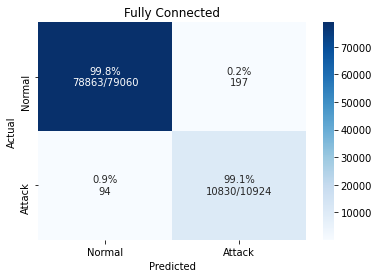

In [29]:
# Run the models on SWaT data
run_models(X_train_swat, X_val_swat, X_test_swat, y_train_swat, y_val_swat, y_test_swat, "org")

# Autoencoder Representation Leanring

Epoch 1/100
687/687 [==============================] - 1s 769us/step - loss: 0.0063 - mse: 0.0063
Epoch 2/100
687/687 [==============================] - 1s 777us/step - loss: 6.7394e-04 - mse: 6.7394e-04
Epoch 3/100
687/687 [==============================] - 1s 763us/step - loss: 3.7325e-04 - mse: 3.7325e-04
Epoch 4/100
687/687 [==============================] - 1s 742us/step - loss: 2.4351e-04 - mse: 2.4351e-04
Epoch 5/100
687/687 [==============================] - 1s 761us/step - loss: 1.8963e-04 - mse: 1.8963e-04
Epoch 6/100
687/687 [==============================] - 1s 776us/step - loss: 1.6566e-04 - mse: 1.6566e-04
Epoch 7/100
687/687 [==============================] - 1s 772us/step - loss: 1.5060e-04 - mse: 1.5060e-04
Epoch 8/100
687/687 [==============================] - 1s 760us/step - loss: 1.3932e-04 - mse: 1.3932e-04
Epoch 9/100
687/687 [==============================] - 1s 755us/step - loss: 1.2568e-04 - mse: 1.2568e-04
Epoch 10/100
687/687 [==============================] 

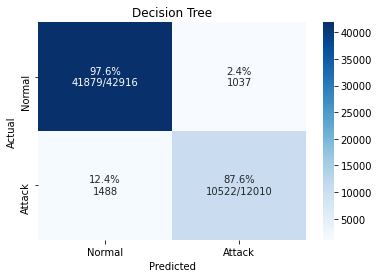


SVM : 
Accuracy: 0.8137494082947966
Precision: 1.0
Recall: 0.1482098251457119
f1-score: 0.2581580855692531


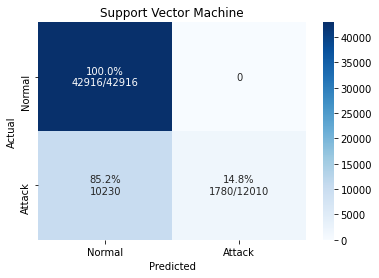


KNN : 
Accuracy: 0.9439609656628919
Precision: 0.8996062992125984
Recall: 0.8371357202331391
f1-score: 0.8672474769257311


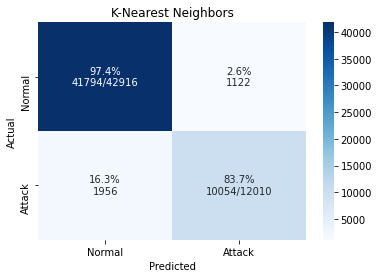


RandomForest :
Accuracy: 0.9553034992535411
Precision: 0.9308323563892146
Recall: 0.8594504579517069
f1-score: 0.893718342785402


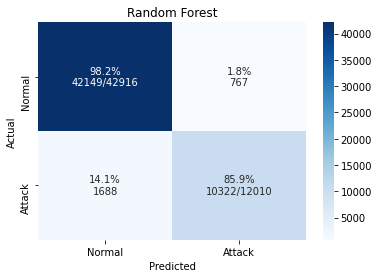


GradientBoost : 
Accuracy: 0.8441539525907584
Precision: 0.9937034917000572
Recall: 0.2890924229808493
f1-score: 0.44788441692466463


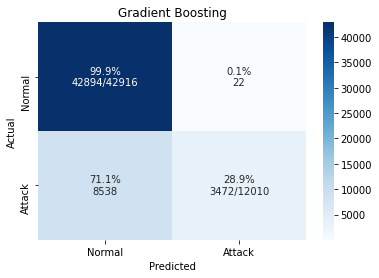


AdaBoost : 
Accuracy: 0.8257109565597349
Precision: 0.972836631742336
Recall: 0.20874271440466277
f1-score: 0.34373071913347497


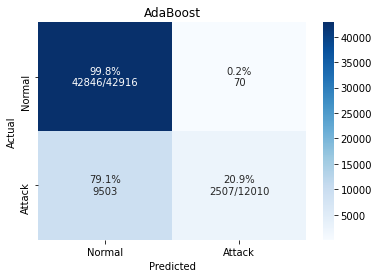

Epoch 1/200
687/687 [==============================] - 1s 1ms/step - loss: 0.4273 - accuracy: 0.8165 - val_loss: 0.3841 - val_accuracy: 0.8348
Epoch 2/200
687/687 [==============================] - 1s 1ms/step - loss: 0.3829 - accuracy: 0.8355 - val_loss: 0.3793 - val_accuracy: 0.8364
Epoch 3/200
687/687 [==============================] - 1s 985us/step - loss: 0.3725 - accuracy: 0.8387 - val_loss: 0.3780 - val_accuracy: 0.8383
Epoch 4/200
687/687 [==============================] - 1s 994us/step - loss: 0.3702 - accuracy: 0.8413 - val_loss: 0.3646 - val_accuracy: 0.8428
Epoch 5/200
687/687 [==============================] - 1s 974us/step - loss: 0.3716 - accuracy: 0.8410 - val_loss: 0.3695 - val_accuracy: 0.8419
Epoch 6/200
687/687 [==============================] - 1s 1ms/step - loss: 0.3654 - accuracy: 0.8432 - val_loss: 0.3636 - val_accuracy: 0.8423
Epoch 7/200
687/687 [==============================] - 1s 979us/step - loss: 0.3696 - accuracy: 0.8421 - val_loss: 0.3593 - val_accuracy

687/687 [==============================] - 1s 967us/step - loss: 0.3232 - accuracy: 0.8566 - val_loss: 0.3267 - val_accuracy: 0.8561
Epoch 114/200
687/687 [==============================] - 1s 955us/step - loss: 0.3218 - accuracy: 0.8567 - val_loss: 0.3272 - val_accuracy: 0.8558
Epoch 115/200
687/687 [==============================] - 1s 985us/step - loss: 0.3238 - accuracy: 0.8563 - val_loss: 0.3241 - val_accuracy: 0.8561
Epoch 116/200
687/687 [==============================] - 1s 954us/step - loss: 0.3988 - accuracy: 0.8507 - val_loss: 0.5786 - val_accuracy: 0.8398
Epoch 117/200
687/687 [==============================] - 1s 968us/step - loss: 0.5704 - accuracy: 0.8414 - val_loss: 0.5732 - val_accuracy: 0.8407
Epoch 118/200
687/687 [==============================] - 1s 953us/step - loss: 0.4092 - accuracy: 0.8508 - val_loss: 0.3310 - val_accuracy: 0.8538
Epoch 119/200
687/687 [==============================] - 1s 978us/step - loss: 0.3229 - accuracy: 0.8568 - val_loss: 0.3295 - val_ac

Epoch 169/200
687/687 [==============================] - 1s 967us/step - loss: 0.3156 - accuracy: 0.8589 - val_loss: 0.3201 - val_accuracy: 0.8578
Epoch 170/200
687/687 [==============================] - 1s 955us/step - loss: 0.3149 - accuracy: 0.8591 - val_loss: 0.3262 - val_accuracy: 0.8563
Epoch 171/200
687/687 [==============================] - 1s 973us/step - loss: 0.3407 - accuracy: 0.8561 - val_loss: 0.3356 - val_accuracy: 0.8555
Epoch 172/200
687/687 [==============================] - 1s 956us/step - loss: 0.3154 - accuracy: 0.8591 - val_loss: 0.3245 - val_accuracy: 0.8572
Epoch 173/200
687/687 [==============================] - 1s 949us/step - loss: 0.3142 - accuracy: 0.8593 - val_loss: 0.3207 - val_accuracy: 0.8585
Epoch 174/200
687/687 [==============================] - 1s 978us/step - loss: 0.3150 - accuracy: 0.8592 - val_loss: 0.3227 - val_accuracy: 0.8574
Epoch 175/200
687/687 [==============================] - 1s 1ms/step - loss: 0.3145 - accuracy: 0.8593 - val_loss: 0.3

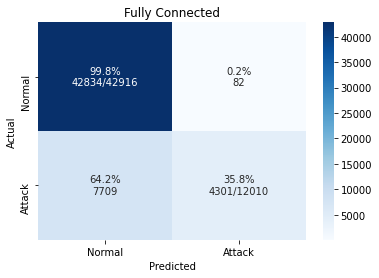

In [30]:
# Get the new representation for the Gas Pipeline dataset and run the models
rep_model_gas = rep_learning(X_train_gas)
X_train_new = rep_model_gas.predict(X_train_gas)
X_test_new = rep_model_gas.predict(X_test_gas)
X_val_new = rep_model_gas.predict(X_val_gas)

run_models(X_train_new, X_val_new, X_test_new, y_train_gas, y_val_gas, y_test_gas, "New Rep")

Epoch 1/100
1125/1125 [==============================] - 1s 972us/step - loss: 0.0110 - mse: 0.0110
Epoch 2/100
1125/1125 [==============================] - 1s 920us/step - loss: 0.0017 - mse: 0.0017
Epoch 3/100
1125/1125 [==============================] - 1s 894us/step - loss: 9.4333e-04 - mse: 9.4333e-04
Epoch 4/100
1125/1125 [==============================] - 1s 904us/step - loss: 6.7858e-04 - mse: 6.7858e-04
Epoch 5/100
1125/1125 [==============================] - 1s 940us/step - loss: 5.2802e-04 - mse: 5.2802e-04
Epoch 6/100
1125/1125 [==============================] - 1s 935us/step - loss: 4.2455e-04 - mse: 4.2455e-04
Epoch 7/100
1125/1125 [==============================] - 1s 921us/step - loss: 3.6762e-04 - mse: 3.6762e-04
Epoch 8/100
1125/1125 [==============================] - 1s 909us/step - loss: 3.2775e-04 - mse: 3.2775e-04
Epoch 9/100
1125/1125 [==============================] - 1s 899us/step - loss: 2.9906e-04 - mse: 2.9906e-04
Epoch 10/100
1125/1125 [====================

1125/1125 [==============================] - 1s 890us/step - loss: 4.9677e-05 - mse: 4.9677e-05
Epoch 77/100
1125/1125 [==============================] - 1s 895us/step - loss: 4.9011e-05 - mse: 4.9011e-05
Epoch 78/100
1125/1125 [==============================] - 1s 897us/step - loss: 4.8056e-05 - mse: 4.8056e-05
Epoch 79/100
1125/1125 [==============================] - 1s 907us/step - loss: 4.7870e-05 - mse: 4.7870e-05
Epoch 80/100
1125/1125 [==============================] - 1s 895us/step - loss: 4.7182e-05 - mse: 4.7182e-05
Epoch 81/100
1125/1125 [==============================] - 1s 891us/step - loss: 4.6712e-05 - mse: 4.6712e-05
Epoch 82/100
1125/1125 [==============================] - 1s 896us/step - loss: 4.5933e-05 - mse: 4.5933e-05
Epoch 83/100
1125/1125 [==============================] - 1s 903us/step - loss: 4.6206e-05 - mse: 4.6206e-05
Epoch 84/100
1125/1125 [==============================] - 1s 885us/step - loss: 4.5016e-05 - mse: 4.5016e-05
Epoch 85/100
1125/1125 [========

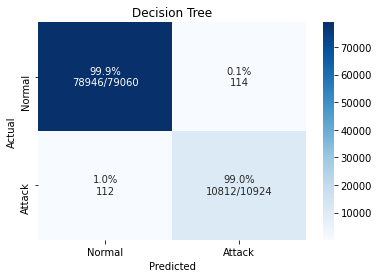


SVM : 
Accuracy: 0.9623710881934566
Precision: 0.9929374836515825
Recall: 0.6949835225192237
f1-score: 0.8176628971459342


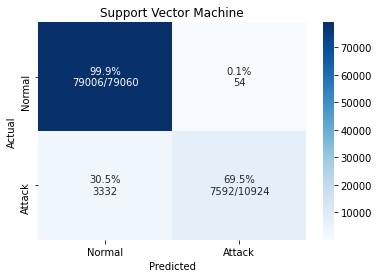


KNN : 
Accuracy: 0.9978996266002845
Precision: 0.991844589022267
Recall: 0.990845844013182
f1-score: 0.9913449649677153


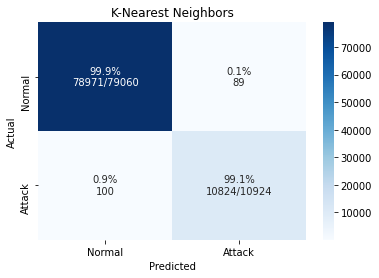


RandomForest :
Accuracy: 0.998799786628734
Precision: 0.9982494932743688
Recall: 0.9918528011717319
f1-score: 0.9950408669299292


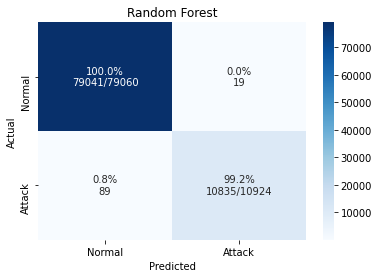


GradientBoost : 
Accuracy: 0.9793518847795164
Precision: 0.9825420481158186
Recall: 0.8449285975833029
f1-score: 0.9085539915345999


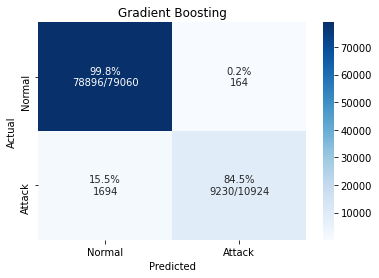


AdaBoost : 
Accuracy: 0.9586370910384068
Precision: 0.9416237429482462
Recall: 0.7028560966678872
f1-score: 0.8049061746514309


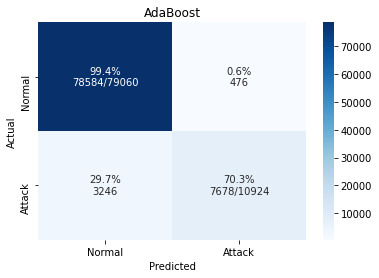

Epoch 1/200
1125/1125 [==============================] - 1s 1ms/step - loss: 0.1061 - accuracy: 0.9745 - val_loss: 0.0748 - val_accuracy: 0.9819
Epoch 2/200
1125/1125 [==============================] - 1s 980us/step - loss: 0.0709 - accuracy: 0.9820 - val_loss: 0.0630 - val_accuracy: 0.9832
Epoch 3/200
1125/1125 [==============================] - 1s 969us/step - loss: 0.0577 - accuracy: 0.9837 - val_loss: 0.0563 - val_accuracy: 0.9842
Epoch 4/200
1125/1125 [==============================] - 1s 973us/step - loss: 0.0473 - accuracy: 0.9867 - val_loss: 0.0408 - val_accuracy: 0.9883
Epoch 5/200
1125/1125 [==============================] - 1s 965us/step - loss: 0.0422 - accuracy: 0.9880 - val_loss: 0.0455 - val_accuracy: 0.9871
Epoch 6/200
1125/1125 [==============================] - 1s 961us/step - loss: 0.0391 - accuracy: 0.9885 - val_loss: 0.0349 - val_accuracy: 0.9889
Epoch 7/200
1125/1125 [==============================] - 1s 980us/step - loss: 0.0353 - accuracy: 0.9893 - val_loss: 0.0

1125/1125 [==============================] - 1s 950us/step - loss: 0.0095 - accuracy: 0.9962 - val_loss: 0.0097 - val_accuracy: 0.9963
Epoch 112/200
1125/1125 [==============================] - 1s 979us/step - loss: 0.0093 - accuracy: 0.9964 - val_loss: 0.0093 - val_accuracy: 0.9967
Epoch 113/200
1125/1125 [==============================] - 1s 964us/step - loss: 0.0095 - accuracy: 0.9962 - val_loss: 0.0104 - val_accuracy: 0.9961
Epoch 114/200
1125/1125 [==============================] - 1s 968us/step - loss: 0.0091 - accuracy: 0.9965 - val_loss: 0.0088 - val_accuracy: 0.9972
Epoch 115/200
1125/1125 [==============================] - 1s 979us/step - loss: 0.0096 - accuracy: 0.9963 - val_loss: 0.0110 - val_accuracy: 0.9961
Epoch 116/200
1125/1125 [==============================] - 1s 979us/step - loss: 0.0091 - accuracy: 0.9964 - val_loss: 0.0114 - val_accuracy: 0.9958
Epoch 117/200
1125/1125 [==============================] - 1s 959us/step - loss: 0.0094 - accuracy: 0.9964 - val_loss: 0

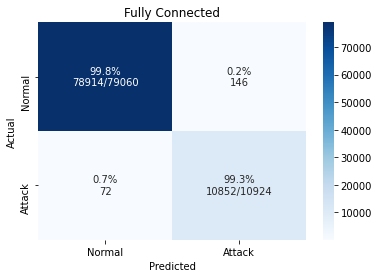

In [31]:
# Get the new representation for the SWaT dataset and run the models
rep_model_swat = rep_learning(X_train_swat)
X_train_new = rep_model_swat.predict(X_train_swat)
X_test_new = rep_model_swat.predict(X_test_swat)
X_val_new = rep_model_swat.predict(X_val_swat)

run_models(X_train_new, X_val_new, X_test_new, y_train_swat, y_val_swat, y_test_swat, "New Rep")

# Random Undersampling

rus_gas

DecisionTree : 
Accuracy: 0.9054364053453737
Precision: 0.7241515390686661
Recall: 0.9167360532889259
f1-score: 0.8091423532005585


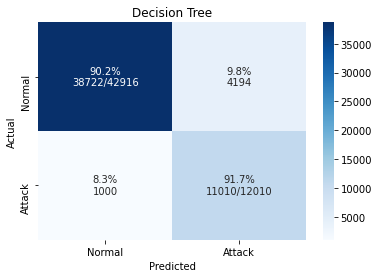


SVM : 
Accuracy: 0.5687834541018826
Precision: 0.31536831451434355
Recall: 0.8302248126561199
f1-score: 0.4571022531918308


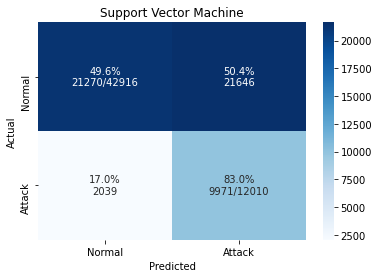


KNN : 
Accuracy: 0.885427666314678
Precision: 0.676920220337934
Recall: 0.9106577851790175
f1-score: 0.776582525650584


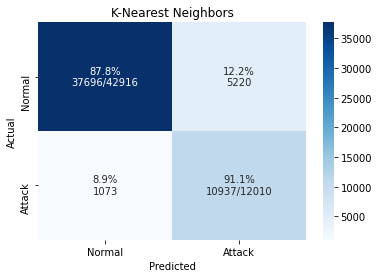


RandomForest :
Accuracy: 0.8968794377890252
Precision: 0.7018447837150127
Recall: 0.9186511240632806
f1-score: 0.7957446808510639


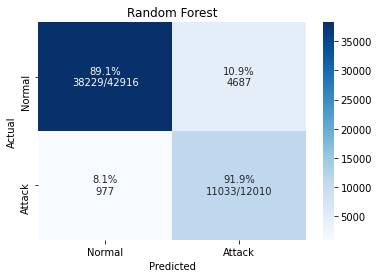


GradientBoost : 
Accuracy: 0.6317044751119688
Precision: 0.36540791930042904
Recall: 0.9289758534554537
f1-score: 0.5245046188562161


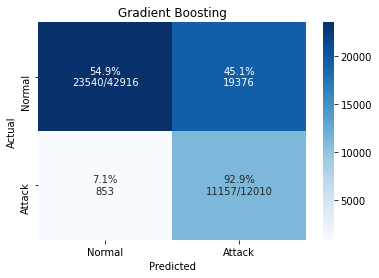


AdaBoost : 
Accuracy: 0.7257764992899538
Precision: 0.4043979451196592
Recall: 0.5374687760199833
f1-score: 0.4615329615329615


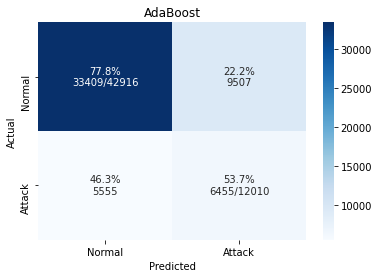

Epoch 1/200
301/301 [==============================] - 0s 1ms/step - loss: 0.6127 - accuracy: 0.6337 - val_loss: 0.6495 - val_accuracy: 0.5350
Epoch 2/200
301/301 [==============================] - 0s 1ms/step - loss: 0.5337 - accuracy: 0.6861 - val_loss: 0.4589 - val_accuracy: 0.7017
Epoch 3/200
301/301 [==============================] - 0s 1ms/step - loss: 0.4941 - accuracy: 0.7099 - val_loss: 0.4557 - val_accuracy: 0.6725
Epoch 4/200
301/301 [==============================] - 0s 1ms/step - loss: 0.4790 - accuracy: 0.7185 - val_loss: 0.4868 - val_accuracy: 0.6044
Epoch 5/200
301/301 [==============================] - 0s 1ms/step - loss: 0.4739 - accuracy: 0.7187 - val_loss: 0.4495 - val_accuracy: 0.6672
Epoch 6/200
301/301 [==============================] - 0s 1ms/step - loss: 0.4694 - accuracy: 0.7208 - val_loss: 0.4567 - val_accuracy: 0.6852
Epoch 7/200
301/301 [==============================] - 0s 1ms/step - loss: 0.4679 - accuracy: 0.7217 - val_loss: 0.4363 - val_accuracy: 0.6489

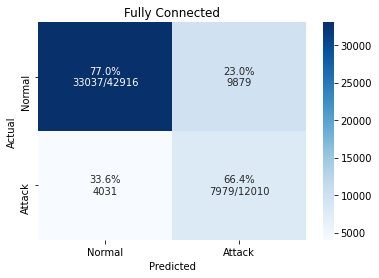

In [32]:
# Undersample the Gas Pipeline dataset
rus_gas = RandomUnderSampler(random_state=42, replacement=True)
X_rus_gas, y_rus_gas = rus_gas.fit_resample(X_train_gas, y_train_gas)   # fit undersampler and target varialbe

run_models(X_rus_gas, X_val_gas, X_test_gas, y_rus_gas, y_val_gas, y_test_gas, "rus_gas")

rus_swat

DecisionTree : 
Accuracy: 0.996966127311522
Precision: 0.9762138960922829
Recall: 0.9993592090809227
f1-score: 0.9876509702809065


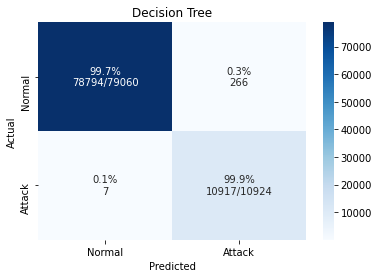


SVM : 
Accuracy: 0.9658828236130867
Precision: 0.9321082746478874
Recall: 0.7754485536433541
f1-score: 0.8465920447731361


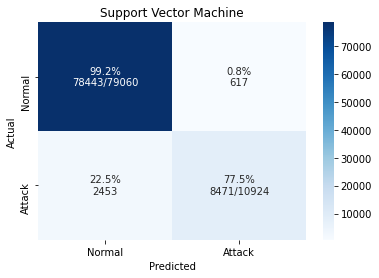


KNN : 
Accuracy: 0.9906538940256046
Precision: 0.9305662311042787
Recall: 0.997436836323691
f1-score: 0.962841868068749


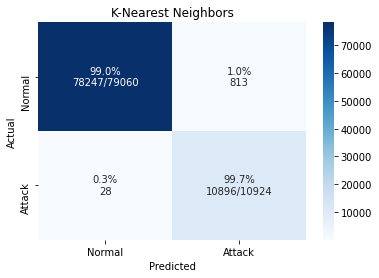


RandomForest :
Accuracy: 0.9984997332859175
Precision: 0.9878809803744234
Recall: 0.9999084584401318
f1-score: 0.9938583321959874


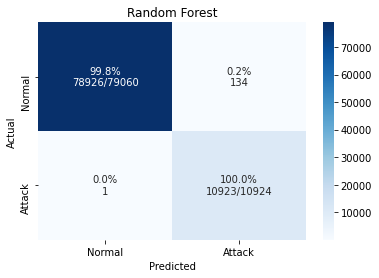


GradientBoost : 
Accuracy: 0.971161539829303
Precision: 0.8790388641121325
Recall: 0.884108385206884
f1-score: 0.8815663365432886


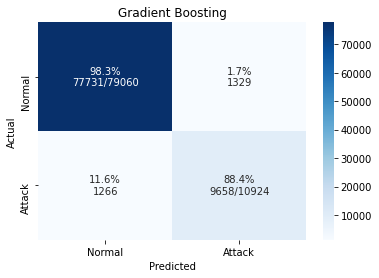


AdaBoost : 
Accuracy: 0.9568034317211949
Precision: 0.8498558218156508
Recall: 0.7824057121933358
f1-score: 0.8147371431294982


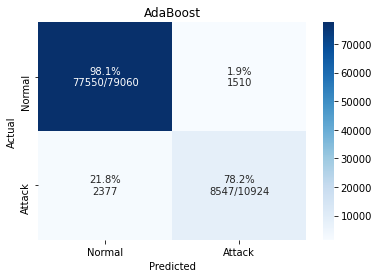

Epoch 1/200
274/274 [==============================] - 1s 2ms/step - loss: 0.3279 - accuracy: 0.8642 - val_loss: 0.3423 - val_accuracy: 0.8790
Epoch 2/200
274/274 [==============================] - 0s 1ms/step - loss: 0.2275 - accuracy: 0.9110 - val_loss: 0.2512 - val_accuracy: 0.9255
Epoch 3/200
274/274 [==============================] - 0s 1ms/step - loss: 0.2067 - accuracy: 0.9197 - val_loss: 0.2436 - val_accuracy: 0.9231
Epoch 4/200
274/274 [==============================] - 0s 1ms/step - loss: 0.1848 - accuracy: 0.9264 - val_loss: 0.2603 - val_accuracy: 0.9018
Epoch 5/200
274/274 [==============================] - 0s 1ms/step - loss: 0.1708 - accuracy: 0.9312 - val_loss: 0.1385 - val_accuracy: 0.9682
Epoch 6/200
274/274 [==============================] - 0s 1ms/step - loss: 0.1591 - accuracy: 0.9360 - val_loss: 0.1562 - val_accuracy: 0.9599
Epoch 7/200
274/274 [==============================] - 0s 1ms/step - loss: 0.1491 - accuracy: 0.9404 - val_loss: 0.1538 - val_accuracy: 0.9489

Epoch 113/200
274/274 [==============================] - 1s 2ms/step - loss: 0.0386 - accuracy: 0.9843 - val_loss: 0.0382 - val_accuracy: 0.9868
Epoch 114/200
274/274 [==============================] - 0s 2ms/step - loss: 0.0377 - accuracy: 0.9851 - val_loss: 0.0333 - val_accuracy: 0.9884
Epoch 115/200
274/274 [==============================] - 0s 1ms/step - loss: 0.0371 - accuracy: 0.9853 - val_loss: 0.0314 - val_accuracy: 0.9896
Epoch 116/200
274/274 [==============================] - 0s 2ms/step - loss: 0.0369 - accuracy: 0.9849 - val_loss: 0.0322 - val_accuracy: 0.9892
Epoch 117/200
274/274 [==============================] - 0s 1ms/step - loss: 0.0370 - accuracy: 0.9846 - val_loss: 0.0467 - val_accuracy: 0.9837
Epoch 118/200
274/274 [==============================] - 0s 1ms/step - loss: 0.0362 - accuracy: 0.9857 - val_loss: 0.0692 - val_accuracy: 0.9754
Epoch 119/200
274/274 [==============================] - 0s 1ms/step - loss: 0.0382 - accuracy: 0.9843 - val_loss: 0.0407 - val_ac

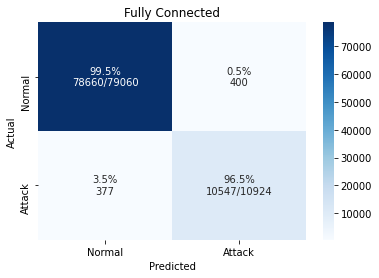

In [33]:
# Undersample the SWaT dataset
rus_swat = RandomUnderSampler(random_state=42, replacement=True)
X_rus_swat, y_rus_swat = rus_swat.fit_resample(X_train_swat, y_train_swat)   # fit undersampler and target varialbe

run_models(X_rus_swat, X_val_swat, X_test_swat, y_rus_swat, y_val_swat, y_test_swat, "rus_swat")

# SMOTE Oversampling

smot_gas

DecisionTree : 
Accuracy: 0.9322360994792994
Precision: 0.8594725884802221
Recall: 0.8249791840133223
f1-score: 0.8418727164584927


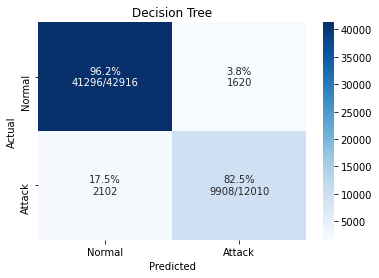


SVM : 
Accuracy: 0.5719513527291264
Precision: 0.3177972814549602
Recall: 0.8351373855120733
f1-score: 0.4603979711275848


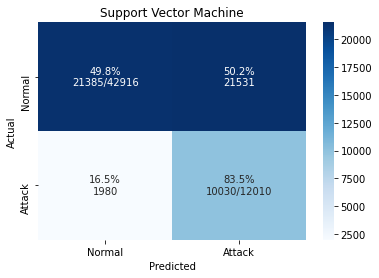


KNN : 
Accuracy: 0.9434147762444015
Precision: 0.8476257419556389
Recall: 0.9036636136552872
f1-score: 0.8747481260578706


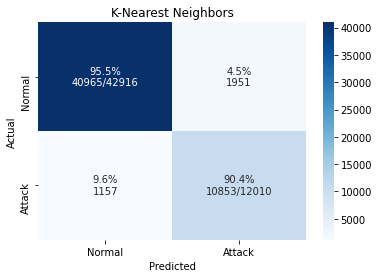


RandomForest :
Accuracy: 0.9330917962349343
Precision: 0.8087265723386917
Recall: 0.908992506244796
f1-score: 0.8559332000470422


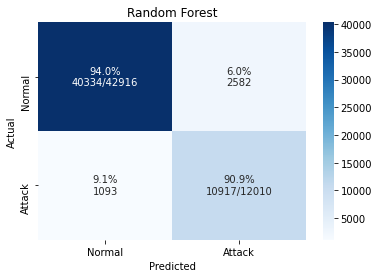


GradientBoost : 
Accuracy: 0.6266613261479081
Precision: 0.358663827521959
Recall: 0.8975853455453788
f1-score: 0.5125279322968669


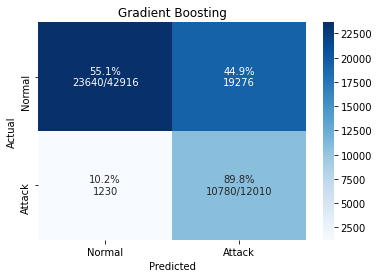


AdaBoost : 
Accuracy: 0.7257947056039035
Precision: 0.4044352565307273
Recall: 0.5375520399666944
f1-score: 0.46158795981839634


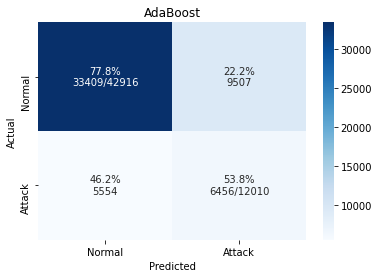

Epoch 1/200
1073/1073 [==============================] - 1s 1ms/step - loss: 0.5296 - accuracy: 0.6858 - val_loss: 0.4361 - val_accuracy: 0.7729
Epoch 2/200
1073/1073 [==============================] - 1s 964us/step - loss: 0.4784 - accuracy: 0.7153 - val_loss: 0.4664 - val_accuracy: 0.6184
Epoch 3/200
1073/1073 [==============================] - 1s 943us/step - loss: 0.4692 - accuracy: 0.7215 - val_loss: 0.4132 - val_accuracy: 0.7463
Epoch 4/200
1073/1073 [==============================] - 1s 932us/step - loss: 0.4647 - accuracy: 0.7244 - val_loss: 0.4478 - val_accuracy: 0.6232
Epoch 5/200
1073/1073 [==============================] - 1s 933us/step - loss: 0.4634 - accuracy: 0.7252 - val_loss: 0.4483 - val_accuracy: 0.6607
Epoch 6/200
1073/1073 [==============================] - 1s 935us/step - loss: 0.4609 - accuracy: 0.7270 - val_loss: 0.4935 - val_accuracy: 0.6143
Epoch 7/200
1073/1073 [==============================] - 1s 926us/step - loss: 0.4591 - accuracy: 0.7294 - val_loss: 0.4

1073/1073 [==============================] - 1s 919us/step - loss: 0.3871 - accuracy: 0.7633 - val_loss: 0.4082 - val_accuracy: 0.6495
Epoch 109/200
1073/1073 [==============================] - 1s 978us/step - loss: 0.3899 - accuracy: 0.7614 - val_loss: 0.4010 - val_accuracy: 0.6708

Fully Connected : 
Accuracy: 0.6750355023122019
Precision: 0.39330482768702263
Recall: 0.8960865945045795
f1-score: 0.546669037157443


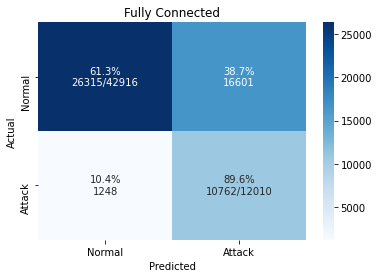

In [34]:
# Oversample and run the models for the Gas pipeline dataset
smot_gas = SMOTE()
X_smot_gas, y_smot_gas = smot_gas.fit_resample(X_train_gas, y_train_gas)   # fit oversampler and target varialbe
run_models(X_smot_gas, X_val_gas, X_test_gas, y_smot_gas, y_val_gas, y_test_gas, "smot_gas")

smot_swat

DecisionTree : 
Accuracy: 0.9995110241820768
Precision: 0.9974396488661302
Recall: 0.9985353350421091
f1-score: 0.9979871912168345


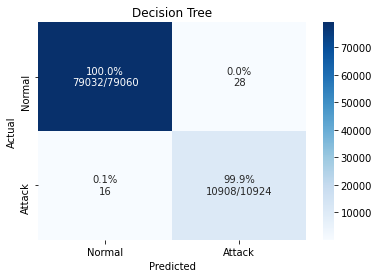


SVM : 
Accuracy: 0.9660161806543386
Precision: 0.9331497797356828
Recall: 0.7756316367630904
f1-score: 0.847130573885223


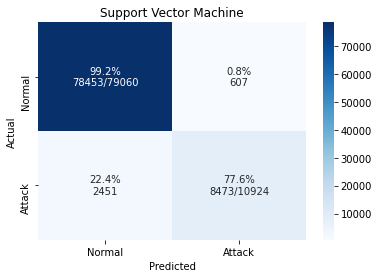


KNN : 
Accuracy: 0.9980440967283073
Precision: 0.9865109541915625
Recall: 0.9975283778835591
f1-score: 0.9919890760127446


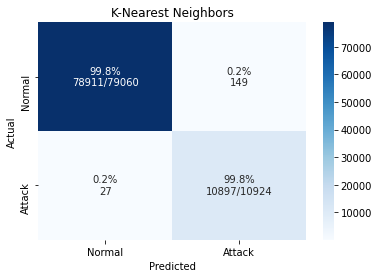


RandomForest :
Accuracy: 0.9998221906116643
Precision: 0.9989023051591658
Recall: 0.9996338337605273
f1-score: 0.9992679355783308


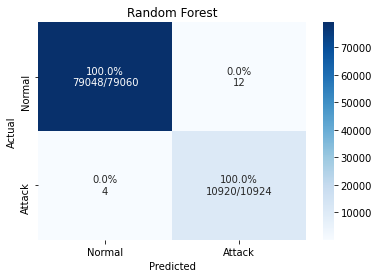


GradientBoost : 
Accuracy: 0.9731174431009957
Precision: 0.8941514505514876
Recall: 0.8831014280483339
f1-score: 0.8885920876894026


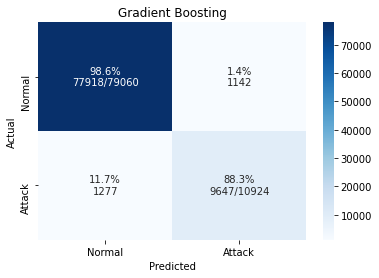


AdaBoost : 
Accuracy: 0.9369221194879089
Precision: 0.7064191315292637
Recall: 0.8220432076162578
f1-score: 0.7598578439668302


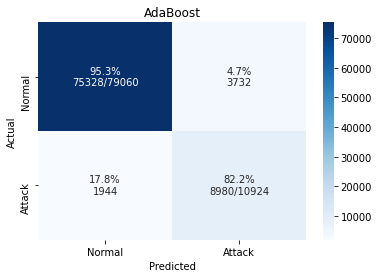

Epoch 1/200
1977/1977 [==============================] - 2s 968us/step - loss: 0.1976 - accuracy: 0.9217 - val_loss: 0.1370 - val_accuracy: 0.9596
Epoch 2/200
1977/1977 [==============================] - 2s 906us/step - loss: 0.1171 - accuracy: 0.9560 - val_loss: 0.0846 - val_accuracy: 0.9781
Epoch 3/200
1977/1977 [==============================] - 2s 910us/step - loss: 0.0861 - accuracy: 0.9671 - val_loss: 0.0608 - val_accuracy: 0.9829
Epoch 4/200
1977/1977 [==============================] - 2s 896us/step - loss: 0.0698 - accuracy: 0.9729 - val_loss: 0.0689 - val_accuracy: 0.9761
Epoch 5/200
1977/1977 [==============================] - 2s 1ms/step - loss: 0.0601 - accuracy: 0.9763 - val_loss: 0.0392 - val_accuracy: 0.9876
Epoch 6/200
1977/1977 [==============================] - 2s 999us/step - loss: 0.0542 - accuracy: 0.9787 - val_loss: 0.0516 - val_accuracy: 0.9815
Epoch 7/200
1977/1977 [==============================] - 2s 950us/step - loss: 0.0509 - accuracy: 0.9795 - val_loss: 0.0

1977/1977 [==============================] - 2s 898us/step - loss: 0.0114 - accuracy: 0.9958 - val_loss: 0.0146 - val_accuracy: 0.9947
Epoch 112/200
1977/1977 [==============================] - 2s 897us/step - loss: 0.0117 - accuracy: 0.9957 - val_loss: 0.0146 - val_accuracy: 0.9946
Epoch 113/200
1977/1977 [==============================] - 2s 900us/step - loss: 0.0115 - accuracy: 0.9958 - val_loss: 0.0108 - val_accuracy: 0.9960
Epoch 114/200
1977/1977 [==============================] - 2s 924us/step - loss: 0.0111 - accuracy: 0.9959 - val_loss: 0.0259 - val_accuracy: 0.9917
Epoch 115/200
1977/1977 [==============================] - 2s 907us/step - loss: 0.0117 - accuracy: 0.9958 - val_loss: 0.0120 - val_accuracy: 0.9958
Epoch 116/200
1977/1977 [==============================] - 2s 901us/step - loss: 0.0114 - accuracy: 0.9958 - val_loss: 0.0167 - val_accuracy: 0.9938
Epoch 117/200
1977/1977 [==============================] - 2s 898us/step - loss: 0.0112 - accuracy: 0.9960 - val_loss: 0

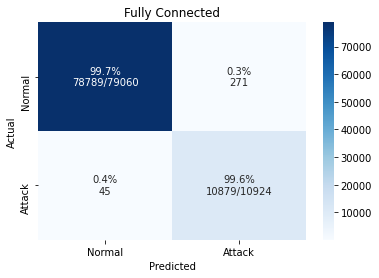

In [35]:
# Oversample and run the models for SWaT dataset
smot_swat = SMOTE()
X_smot_swat, y_smot_swat = smot_swat.fit_resample(X_train_swat, y_train_swat)   # fit oversampler and target varialbe

run_models(X_smot_swat, X_val_swat, X_test_swat, y_smot_swat, y_val_swat, y_test_swat, "smot_swat")